This file is for evaluating the performance of methods on large tabular datasets.

In [1]:
!echo $HOSTNAME

amueller-4gpu-eastus2-2


In [2]:
import matplotlib.pyplot as plt

from ticl.evaluation.baselines import tabular_baselines

import seaborn as sns
import numpy as np
import warnings
warnings.simplefilter("ignore", FutureWarning)  # openml deprecation of array return type
from ticl.datasets import load_openml_list, open_cc_valid_dids, open_cc_dids, open_cc_large_dids, new_valid_dids
from ticl.evaluation.baselines.tabular_baselines import knn_metric, catboost_metric, logistic_metric, xgb_metric, random_forest_metric, mlp_metric, hyperfast_metric, hyperfast_metric_tuning, resnet_metric, mothernet_init_metric
from ticl.evaluation.tabular_evaluation import evaluate, eval_on_datasets, transformer_metric
from ticl.evaluation import tabular_metrics
from ticl.prediction.tabpfn import TabPFNClassifier
import os
from ticl.evaluation.baselines.distill_mlp import DistilledTabPFNMLP
from ticl.prediction.mothernet import MotherNetClassifier
from functools import partial
from ticl.evaluation.tabular_evaluation import eval_on_datasets
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from ticl.prediction.mothernet import ShiftClassifier, EnsembleMeta, MotherNetClassifier
from sklearn.impute import SimpleImputer
from ticl.prediction.mothernet_additive import MotherNetAdditiveClassifier

from interpret.glassbox import ExplainableBoostingClassifier


from hyperfast import HyperFastClassifier

# transformers don't have max times
import warnings
import pandas as pd

import datetime

import pickle

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Datasets

In [3]:
max_features = 5000
max_num_classes = 100
n_samples = 1000000

In [13]:
cc_test_datasets_multiclass, cc_test_datasets_multiclass_df = load_openml_list(
    # new_valid_dids, 
    open_cc_large_dids,
    # open_cc_valid_dids,
    # [1491, 41986, 42343],
    multiclass=True,
    shuffled=True, 
    filter_for_nan=False, 
    max_samples = n_samples, 
    num_feats=max_features, 
    max_num_classes=max_num_classes,
    return_capped=True
)

/datadrive/tabpfn_training_amueller/mothernet/datasets/__init__.py:164: FutureWarning: Support for `output_format` of 'dict' will be removed in 0.15 and pandas dataframes will be returned instead. To ensure your code will continue to work, use `output_format`='dataframe'.
  openml_list = openml.datasets.list_datasets(dids)


Number of datasets: 19


In [14]:
eval_positions = [5000000]
base_path = os.path.join('../')
overwrite = False
# max_times only affect non-nn models, nn models are not affected by max_times
# for non-nn models, when the runtime is longer than the max_time, it should stop
max_times = [1, 15, 30, 60, 60 * 5, 60 * 15, 60*60] 
metric_used = tabular_metrics.auc_metric
task_type = 'multiclass'

In [15]:
!mkdir -p {base_path}/results
!mkdir -p {base_path}/results/tabular/
!mkdir -p {base_path}/results/tabular/multiclass/

In [16]:
cc_test_datasets_multiclass_df['isNumeric'] = (
    cc_test_datasets_multiclass_df.NumberOfSymbolicFeatures == 1
    ) & (cc_test_datasets_multiclass_df.NumberOfInstancesWithMissingValues == 0)

In [17]:
cc_test_datasets_multiclass_df['NumberOfInstances'] =  cc_test_datasets_multiclass_df['NumberOfInstances'].astype(int)
cc_test_datasets_multiclass_df['NumberOfFeatures'] =  cc_test_datasets_multiclass_df['NumberOfFeatures'].astype(int)
cc_test_datasets_multiclass_df['NumberOfClasses'] =  cc_test_datasets_multiclass_df['NumberOfClasses'].astype(int)

print(cc_test_datasets_multiclass_df[['did', 'name', 'NumberOfFeatures', 'NumberOfInstances', 'NumberOfClasses']].rename(columns={'NumberOfFeatures': "d", "NumberOfInstances":"n", "NumberOfClasses": "k"}).to_latex(index=False))

\begin{tabular}{rlrrr}
\toprule
did & name & d & n & k \\
\midrule
137 & BNG(tic-tac-toe) & 10 & 39366 & 2 \\
843 & house_8L & 9 & 22784 & 2 \\
846 & elevators & 19 & 16599 & 2 \\
981 & kdd_internet_usage & 69 & 10108 & 2 \\
1220 & Click_prediction_small & 10 & 39948 & 2 \\
1459 & artificial-characters & 8 & 10218 & 10 \\
1461 & bank-marketing & 17 & 45211 & 2 \\
1531 & volcanoes-b1 & 4 & 10176 & 5 \\
1532 & volcanoes-b2 & 4 & 10668 & 5 \\
1590 & adult & 15 & 48842 & 2 \\
4135 & Amazon_employee_access & 10 & 32769 & 2 \\
4534 & PhishingWebsites & 31 & 11055 & 2 \\
23512 & higgs & 29 & 98050 & 2 \\
40668 & connect-4 & 43 & 67557 & 3 \\
41027 & jungle_chess_2pcs_raw_endgame_complete & 7 & 44819 & 3 \\
41162 & kick & 33 & 72983 & 2 \\
41168 & jannis & 55 & 83733 & 4 \\
42733 & Click_prediction_small & 12 & 39948 & 2 \\
42734 & okcupid-stem & 20 & 50789 & 3 \\
\bottomrule
\end{tabular}



In [18]:
preview = cc_test_datasets_multiclass_df[['did', 'name', 'NumberOfFeatures', 'NumberOfInstances', 'NumberOfClasses']].reset_index(drop=True)
preview

,did,name,NumberOfFeatures,NumberOfInstances,NumberOfClasses
0,137,BNG(tic-tac-toe),10,39366,2
1,843,house_8L,9,22784,2
2,846,elevators,19,16599,2
3,981,kdd_internet_usage,69,10108,2
4,1220,Click_prediction_small,10,39948,2
5,1459,artificial-characters,8,10218,10
6,1461,bank-marketing,17,45211,2
7,1531,volcanoes-b1,4,10176,5
8,1532,volcanoes-b2,4,10668,5
9,1590,adult,15,48842,2


# Method Evaluation
This section runs baselines and saves results locally.

In [29]:
max_times = [10000000]
device = "cuda"

results_tabpfn = []

tabpfn_models = {
    # 'ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples10000_08_01_2024_20_58_55': ('SSMTabPFN+10000', 'on_exit'),
    'prior_diff_real_checkpoint_n_0': ('TabPFN+1000', 100, min(n_samples, 3000)),
    'ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50': ('SSMTabPFN+50000', 110, n_samples),
    # 'ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples1000_08_02_2024_17_14_16': ('SSMTabPFN+1000', 'on_exit'),
    'ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40': ('TabFlex+50000', 430, min(n_samples, 3000)),
}

for model_string in tabpfn_models:
    model = TabPFNClassifier(
        device=device, 
        model_string=model_string, 
        epoch=tabpfn_models[model_string][1], 
        N_ensemble_configurations=3,
    )

    result = eval_on_datasets(
        'multiclass', 
        model, 
        model_string, 
        cc_test_datasets_multiclass, 
        eval_positions=eval_positions, 
        max_times=max_times,
        metric_used=metric_used, 
        split_numbers=[1,2,3,4,5],
        n_samples=n_samples, 
        base_path=base_path, 
        overwrite=False, 
        fetch_only=True,
        n_jobs=1, 
        device=device,
    )
    
    results_tabpfn.append(result)

# store the results as pickle
with open(f'{base_path}/results/tabular/multiclass/tabpfn_summary.pkl', 'wb') as f:
    pickle.dump(results_tabpfn, f)
    

evaluating prior_diff_real_checkpoint_n_0 on cuda


evaluating prior_diff_real_checkpoint_n_0 on cuda Click_prediction_small:   8%|▊         | 8/95 [00:00<00:01, 77.23it/s]

Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_BNG(tic-tac-toe)_19683_39366_1_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_BNG(tic-tac-toe)_19683_39366_2_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_BNG(tic-tac-toe)_19683_39366_3_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_BNG(tic-tac-toe)_19683_39366_4_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_BNG(tic-tac-toe)_19683_39366_5_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_house_8L_11392_22784_1_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_

evaluating prior_diff_real_checkpoint_n_0 on cuda artificial-characters:  27%|██▋       | 26/95 [00:00<00:00, 104.24it/s]

Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_artificial-characters_5109_10218_1_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_artificial-characters_5109_10218_2_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_artificial-characters_5109_10218_3_cuda.npy


evaluating prior_diff_real_checkpoint_n_0 on cuda artificial-characters:  27%|██▋       | 26/95 [00:00<00:00, 104.24it/s]

Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_artificial-characters_5109_10218_4_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_artificial-characters_5109_10218_5_cuda.npy


evaluating prior_diff_real_checkpoint_n_0 on cuda volcanoes-b2:  46%|████▋     | 44/95 [00:01<00:01, 37.22it/s]          

Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_bank-marketing_22605_45210_1_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_bank-marketing_22605_45210_2_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_bank-marketing_22605_45210_3_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_bank-marketing_22605_45210_4_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_bank-marketing_22605_45210_5_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_volcanoes-b1_5088_10176_1_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpo

evaluating prior_diff_real_checkpoint_n_0 on cuda higgs:  54%|█████▎    | 51/95 [00:01<00:01, 39.76it/s]                 

Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_adult_24421_48842_1_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_adult_24421_48842_2_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_adult_24421_48842_3_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_adult_24421_48842_4_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_adult_24421_48842_5_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_Amazon_employee_access_16384_32768_1_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_Amaz

evaluating prior_diff_real_checkpoint_n_0 on cuda connect-4:  66%|██████▋   | 63/95 [00:01<00:00, 54.07it/s]

Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_higgs_49025_98050_3_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_higgs_49025_98050_4_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_higgs_49025_98050_5_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_connect-4_33778_67556_1_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_connect-4_33778_67556_2_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_connect-4_33778_67556_3_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_connect-4

evaluating prior_diff_real_checkpoint_n_0 on cuda kick:  75%|███████▍  | 71/95 [00:01<00:00, 42.50it/s]                                  

Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_connect-4_33778_67556_5_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_jungle_chess_2pcs_raw_endgame_complete_22409_44818_1_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_jungle_chess_2pcs_raw_endgame_complete_22409_44818_2_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_jungle_chess_2pcs_raw_endgame_complete_22409_44818_3_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_jungle_chess_2pcs_raw_endgame_complete_22409_44818_4_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_jungle_chess_2pcs_raw_endgame

evaluating prior_diff_real_checkpoint_n_0 on cuda jannis:  82%|████████▏ | 78/95 [00:01<00:00, 41.94it/s]

Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_kick_36491_72982_2_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_kick_36491_72982_3_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_kick_36491_72982_4_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_kick_36491_72982_5_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_jannis_41866_83732_1_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_jannis_41866_83732_2_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_jannis_41866_83732_3_cu

evaluating prior_diff_real_checkpoint_n_0 on cuda okcupid-stem:  95%|█████████▍| 90/95 [00:02<00:00, 37.83it/s]          

Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_jannis_41866_83732_4_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_jannis_41866_83732_5_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_Click_prediction_small_19974_39948_1_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_Click_prediction_small_19974_39948_2_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_Click_prediction_small_19974_39948_3_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_Click_prediction_small_19974_39948_4_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prio

evaluating prior_diff_real_checkpoint_n_0 on cuda okcupid-stem: 100%|██████████| 95/95 [00:02<00:00, 41.35it/s]


Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_okcupid-stem_25394_50788_2_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_okcupid-stem_25394_50788_3_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_okcupid-stem_25394_50788_4_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_prior_diff_real_checkpoint_n_0_time_10000000_roc_auc_okcupid-stem_25394_50788_5_cuda.npy
evaluating ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50 on cuda


evaluating ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50 on cuda house_8L:   0%|          | 0/95 [00:00<?, ?it/s]        

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_BNG(tic-tac-toe)_19683_39366_1_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_BNG(tic-tac-toe)_19683_39366_2_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_BNG(tic-tac-toe)_19683_39366_3_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_BNG(tic-tac-toe)_19683_39366_4_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10

evaluating ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50 on cuda Click_prediction_small:   8%|▊         | 8/95 [00:00<00:01, 78.56it/s]

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_house_8L_11392_22784_2_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_house_8L_11392_22784_3_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_house_8L_11392_22784_4_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_house_8L_11392_22784_5_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_elevators_8299_16

evaluating ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50 on cuda artificial-characters:  24%|██▍       | 23/95 [00:00<00:00, 113.67it/s] 

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_Click_prediction_small_19974_39948_4_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_Click_prediction_small_19974_39948_5_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_artificial-characters_5109_10218_1_cuda.npy


evaluating ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50 on cuda artificial-characters:  24%|██▍       | 23/95 [00:00<00:00, 113.67it/s]

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_artificial-characters_5109_10218_2_cuda.npy


evaluating ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50 on cuda artificial-characters:  24%|██▍       | 23/95 [00:00<00:00, 113.67it/s]

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_artificial-characters_5109_10218_3_cuda.npy


evaluating ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50 on cuda artificial-characters:  24%|██▍       | 23/95 [00:00<00:00, 113.67it/s]

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_artificial-characters_5109_10218_4_cuda.npy


evaluating ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50 on cuda artificial-characters:  24%|██▍       | 23/95 [00:00<00:00, 113.67it/s]

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_artificial-characters_5109_10218_5_cuda.npy


evaluating ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50 on cuda volcanoes-b2:  37%|███▋      | 35/95 [00:01<00:02, 28.61it/s]          

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_bank-marketing_22605_45210_1_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_bank-marketing_22605_45210_2_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_bank-marketing_22605_45210_3_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_bank-marketing_22605_45210_4_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_r

evaluating ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50 on cuda volcanoes-b2:  44%|████▍     | 42/95 [00:01<00:01, 33.45it/s]

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_volcanoes-b2_5334_10668_2_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_volcanoes-b2_5334_10668_3_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_volcanoes-b2_5334_10668_4_cuda.npy


evaluating ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50 on cuda Amazon_employee_access:  52%|█████▏    | 49/95 [00:01<00:01, 38.36it/s]

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_volcanoes-b2_5334_10668_5_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_adult_24421_48842_1_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_adult_24421_48842_2_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_adult_24421_48842_3_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_adult_24421_48842_4_cud

evaluating ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50 on cuda higgs:  61%|██████    | 58/95 [00:01<00:00, 47.27it/s]                 

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_Amazon_employee_access_16384_32768_5_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_PhishingWebsites_5527_11054_1_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_PhishingWebsites_5527_11054_2_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_PhishingWebsites_5527_11054_3_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time

evaluating ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50 on cuda connect-4:  61%|██████    | 58/95 [00:01<00:00, 47.27it/s]

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_higgs_49025_98050_2_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_higgs_49025_98050_3_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_higgs_49025_98050_4_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_higgs_49025_98050_5_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_connect-4_33778_67556_1_cuda.

evaluating ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50 on cuda connect-4:  69%|██████▉   | 66/95 [00:01<00:00, 43.41it/s]

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_connect-4_33778_67556_2_cuda.npy


evaluating ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50 on cuda connect-4:  69%|██████▉   | 66/95 [00:01<00:00, 43.41it/s]

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_connect-4_33778_67556_3_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_connect-4_33778_67556_4_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_connect-4_33778_67556_5_cuda.npy


evaluating ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50 on cuda jungle_chess_2pcs_raw_endgame_complete:  76%|███████▌  | 72/95 [00:01<00:00, 35.68it/s]

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_jungle_chess_2pcs_raw_endgame_complete_22409_44818_1_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_jungle_chess_2pcs_raw_endgame_complete_22409_44818_2_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_jungle_chess_2pcs_raw_endgame_complete_22409_44818_3_cuda.npy


evaluating ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50 on cuda kick:  81%|████████  | 77/95 [00:01<00:00, 36.83it/s]                                  

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_jungle_chess_2pcs_raw_endgame_complete_22409_44818_4_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_jungle_chess_2pcs_raw_endgame_complete_22409_44818_5_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_kick_36491_72982_1_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_kick_36491_72982_2_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2

evaluating ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50 on cuda jannis:  81%|████████  | 77/95 [00:01<00:00, 36.83it/s]

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_kick_36491_72982_5_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_jannis_41866_83732_1_cuda.npy


evaluating ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50 on cuda jannis:  86%|████████▋ | 82/95 [00:02<00:00, 34.92it/s]

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_jannis_41866_83732_2_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_jannis_41866_83732_3_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_jannis_41866_83732_4_cuda.npy


evaluating ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50 on cuda jannis:  86%|████████▋ | 82/95 [00:02<00:00, 34.92it/s]

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_jannis_41866_83732_5_cuda.npy


evaluating ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50 on cuda Click_prediction_small:  92%|█████████▏| 87/95 [00:02<00:00, 29.12it/s]

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_Click_prediction_small_19974_39948_1_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_Click_prediction_small_19974_39948_2_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_Click_prediction_small_19974_39948_3_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_Click_prediction_small_19974_39948_4_cuda.npy


evaluating ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50 on cuda okcupid-stem:  92%|█████████▏| 87/95 [00:02<00:00, 29.12it/s]          

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_Click_prediction_small_19974_39948_5_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_okcupid-stem_25394_50788_1_cuda.npy


evaluating ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50 on cuda okcupid-stem:  96%|█████████▌| 91/95 [00:02<00:00, 26.63it/s]

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_okcupid-stem_25394_50788_2_cuda.npy


evaluating ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50 on cuda okcupid-stem:  96%|█████████▌| 91/95 [00:02<00:00, 26.63it/s]

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_okcupid-stem_25394_50788_3_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_okcupid-stem_25394_50788_4_cuda.npy


evaluating ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50 on cuda okcupid-stem: 100%|██████████| 95/95 [00:02<00:00, 33.88it/s]


Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50_time_10000000_roc_auc_okcupid-stem_25394_50788_5_cuda.npy
evaluating ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40 on cuda


evaluating ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40 on cuda house_8L:   0%|          | 0/95 [00:00<?, ?it/s]        

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_BNG(tic-tac-toe)_19683_39366_1_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_BNG(tic-tac-toe)_19683_39366_2_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_BNG(tic-tac-toe)_19683_39366_3_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_BNG(tic-tac-toe)_19683_39366_4_cuda.npy
Loaded saved result for ../results/tabular/multiclas

evaluating ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40 on cuda artificial-characters:  15%|█▍        | 14/95 [00:00<00:00, 135.22it/s] 

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_house_8L_11392_22784_3_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_house_8L_11392_22784_4_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_house_8L_11392_22784_5_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_elevators_8299_16598_1_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumcl

evaluating ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40 on cuda artificial-characters:  15%|█▍        | 14/95 [00:00<00:00, 135.22it/s]

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_artificial-characters_5109_10218_2_cuda.npy

evaluating ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40 on cuda artificial-characters:  15%|█▍        | 14/95 [00:00<00:00, 135.22it/s]


Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_artificial-characters_5109_10218_3_cuda.npy


evaluating ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40 on cuda artificial-characters:  29%|██▉       | 28/95 [00:00<00:01, 40.24it/s] 

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_artificial-characters_5109_10218_4_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_artificial-characters_5109_10218_5_cuda.npy


evaluating ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40 on cuda volcanoes-b1:  38%|███▊      | 36/95 [00:01<00:01, 31.65it/s]         

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_bank-marketing_22605_45210_1_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_bank-marketing_22605_45210_2_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_bank-marketing_22605_45210_3_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_bank-marketing_22605_45210_4_cuda.npy
Loaded saved result for ../results/tabular/multiclass/result

evaluating ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40 on cuda adult:  51%|█████     | 48/95 [00:01<00:01, 37.04it/s]       

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_volcanoes-b1_5088_10176_5_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_volcanoes-b2_5334_10668_1_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_volcanoes-b2_5334_10668_2_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_volcanoes-b2_5334_10668_3_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn

evaluating ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40 on cuda higgs:  65%|██████▌   | 62/95 [00:01<00:00, 48.45it/s]                 

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_adult_24421_48842_5_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_Amazon_employee_access_16384_32768_1_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_Amazon_employee_access_16384_32768_2_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_Amazon_employee_access_16384_32768_3_cuda.npy
Loaded saved result for ../results/tabular/mu

evaluating ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40 on cuda connect-4:  65%|██████▌   | 62/95 [00:01<00:00, 48.45it/s]

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_higgs_49025_98050_5_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_connect-4_33778_67556_1_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_connect-4_33778_67556_2_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_connect-4_33778_67556_3_cuda.npy


evaluating ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40 on cuda jungle_chess_2pcs_raw_endgame_complete:  72%|███████▏  | 68/95 [00:01<00:00, 36.11it/s]

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_connect-4_33778_67556_4_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_connect-4_33778_67556_5_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_jungle_chess_2pcs_raw_endgame_complete_22409_44818_1_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_jungle_chess_2pcs_raw_endgame_complete_22409_44818_2_cuda.npy


evaluating ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40 on cuda jannis:  83%|████████▎ | 79/95 [00:02<00:00, 34.22it/s]                                

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_jungle_chess_2pcs_raw_endgame_complete_22409_44818_3_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_jungle_chess_2pcs_raw_endgame_complete_22409_44818_4_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_jungle_chess_2pcs_raw_endgame_complete_22409_44818_5_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_kick_36491_72982_1_cuda.np

evaluating ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40 on cuda jannis:  83%|████████▎ | 79/95 [00:02<00:00, 34.22it/s]

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_jannis_41866_83732_2_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_jannis_41866_83732_3_cuda.npy


evaluating ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40 on cuda jannis:  88%|████████▊ | 84/95 [00:02<00:00, 20.34it/s]

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_jannis_41866_83732_4_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_jannis_41866_83732_5_cuda.npy


evaluating ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40 on cuda okcupid-stem:  93%|█████████▎| 88/95 [00:03<00:00, 17.93it/s]          

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_Click_prediction_small_19974_39948_1_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_Click_prediction_small_19974_39948_2_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_Click_prediction_small_19974_39948_3_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_Click_prediction_small_19974_39948_4_cuda.npy
Loaded saved result for ../r

evaluating ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40 on cuda okcupid-stem:  99%|█████████▉| 94/95 [00:03<00:00, 17.97it/s]

Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_okcupid-stem_25394_50788_2_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_okcupid-stem_25394_50788_3_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_okcupid-stem_25394_50788_4_cuda.npy
Loaded saved result for ../results/tabular/multiclass/results_ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40_time_10000000_roc_auc_okcupid-stem_25394_50788_5_cuda.npy


evaluating ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40 on cuda okcupid-stem: 100%|██████████| 95/95 [00:03<00:00, 28.53it/s]


# Results Preview

In [30]:
flat_results = []
for per_dataset in results_tabpfn:
    for result in per_dataset:
        row = {}
        for key in ['dataset', 'model', 'mean_metric', 'split', 'max_time']:
            row[key] = result[key]
        try:
            best_configs_key, = [k for k in result.keys() if "best_configs" in k]
        except ValueError:
            continue
        if result[best_configs_key][0] is not None:
            row.update(result[best_configs_key][0])
        row['mean_metric'] = float(row["mean_metric"].numpy())
        flat_results.append(row)

results_df = pd.DataFrame(flat_results)

In [31]:
results_view = results_df[['model', 'dataset', 'fit_time', 'inference_time', 'mean_metric']].copy()
# compute the mean of fit time and inference time across different splits when the model and datasets are the same
# and the rows should be reduced
results_view = results_view.groupby(['model', 'dataset']).mean().reset_index()
results_view



,model,dataset,fit_time,inference_time,mean_metric
0,prior_diff_real_checkpoint_n_0,Amazon_employee_access,0.001530,2.464478,0.627332
1,prior_diff_real_checkpoint_n_0,BNG(tic-tac-toe),0.160166,3.391780,0.835550
2,prior_diff_real_checkpoint_n_0,Click_prediction_small,0.002036,3.382151,0.652219
3,prior_diff_real_checkpoint_n_0,PhishingWebsites,0.000931,0.701841,0.992809
4,prior_diff_real_checkpoint_n_0,adult,0.002183,5.237308,0.900397
5,prior_diff_real_checkpoint_n_0,artificial-characters,0.001134,0.405042,0.959422
6,prior_diff_real_checkpoint_n_0,bank-marketing,0.002250,4.576608,0.897934
7,prior_diff_real_checkpoint_n_0,connect-4,0.003837,10.753785,0.632694
8,prior_diff_real_checkpoint_n_0,elevators,0.001025,0.992180,0.946148
9,prior_diff_real_checkpoint_n_0,higgs,0.005334,21.738237,0.733612


In [32]:
results_view.model

0                        prior_diff_real_checkpoint_n_0
1                        prior_diff_real_checkpoint_n_0
2                        prior_diff_real_checkpoint_n_0
3                        prior_diff_real_checkpoint_n_0
4                        prior_diff_real_checkpoint_n_0
5                        prior_diff_real_checkpoint_n_0
6                        prior_diff_real_checkpoint_n_0
7                        prior_diff_real_checkpoint_n_0
8                        prior_diff_real_checkpoint_n_0
9                        prior_diff_real_checkpoint_n_0
10                       prior_diff_real_checkpoint_n_0
11                       prior_diff_real_checkpoint_n_0
12                       prior_diff_real_checkpoint_n_0
13                       prior_diff_real_checkpoint_n_0
14                       prior_diff_real_checkpoint_n_0
15                       prior_diff_real_checkpoint_n_0
16                       prior_diff_real_checkpoint_n_0
17                       prior_diff_real_checkpo

In [33]:
cols = ['fit_time', 'inference_time', 'mean_metric']

# Pivot the table
pivot_table = results_view.pivot(index='dataset', columns='model', values=cols)

# Flatten column names
pivot_table.columns = [f'{col[1]}_{col[0]}' for col in pivot_table.columns]

# Reset index to make 'dataset' a column
pivot_table = pivot_table.reset_index()

columns_mapping = {f'{model_string}_{col}': f'{tabpfn_models[model_string][0]}_{col}' for model_string in tabpfn_models for col in cols}

# Rename columns for clarity
pivot_table = pivot_table.rename(columns=columns_mapping)
pivot_table

,dataset,TabPFN+1000_fit_time,SSMTabPFN+50000_fit_time,TabFlex+50000_fit_time,TabPFN+1000_inference_time,SSMTabPFN+50000_inference_time,TabFlex+50000_inference_time,TabPFN+1000_mean_metric,SSMTabPFN+50000_mean_metric,TabFlex+50000_mean_metric
0,Amazon_employee_access,0.001530,0.001785,0.001518,2.464478,1.309624,1.033678,0.627332,0.638652,0.604200
1,BNG(tic-tac-toe),0.160166,0.228126,0.106709,3.391780,1.635155,1.240755,0.835550,0.832361,0.795942
2,Click_prediction_small,0.002036,0.003712,0.001944,3.382151,1.650382,0.965094,0.652219,0.680016,0.644607
3,PhishingWebsites,0.000931,0.001057,0.000806,0.701841,1.149042,0.538752,0.992809,0.990868,0.973551
4,adult,0.002183,0.002396,0.002296,5.237308,2.084496,1.373281,0.900397,0.905423,0.897492
5,artificial-characters,0.001134,0.001004,0.000996,0.405042,0.678908,0.366777,0.959422,0.948685,0.910467
6,bank-marketing,0.002250,0.002064,0.002102,4.576608,2.012559,1.384182,0.897934,0.901204,0.891059
7,connect-4,0.003837,0.003516,0.003528,10.753785,3.465908,2.948026,0.632694,0.701240,0.613437
8,elevators,0.001025,0.001191,0.001075,0.992180,1.060350,0.728373,0.946148,0.947827,0.941004
9,higgs,0.005334,0.005174,0.004740,21.738237,4.634073,4.100226,0.733612,0.749937,0.680797


In [34]:
pivot_table.columns

Index(['dataset', 'TabPFN+1000_fit_time', 'SSMTabPFN+50000_fit_time',
       'TabFlex+50000_fit_time', 'TabPFN+1000_inference_time',
       'SSMTabPFN+50000_inference_time', 'TabFlex+50000_inference_time',
       'TabPFN+1000_mean_metric', 'SSMTabPFN+50000_mean_metric',
       'TabFlex+50000_mean_metric'],
      dtype='object')

/tmp/ipykernel_2984227/4290107290.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set3')(np.linspace(0, 1, len(methods)))


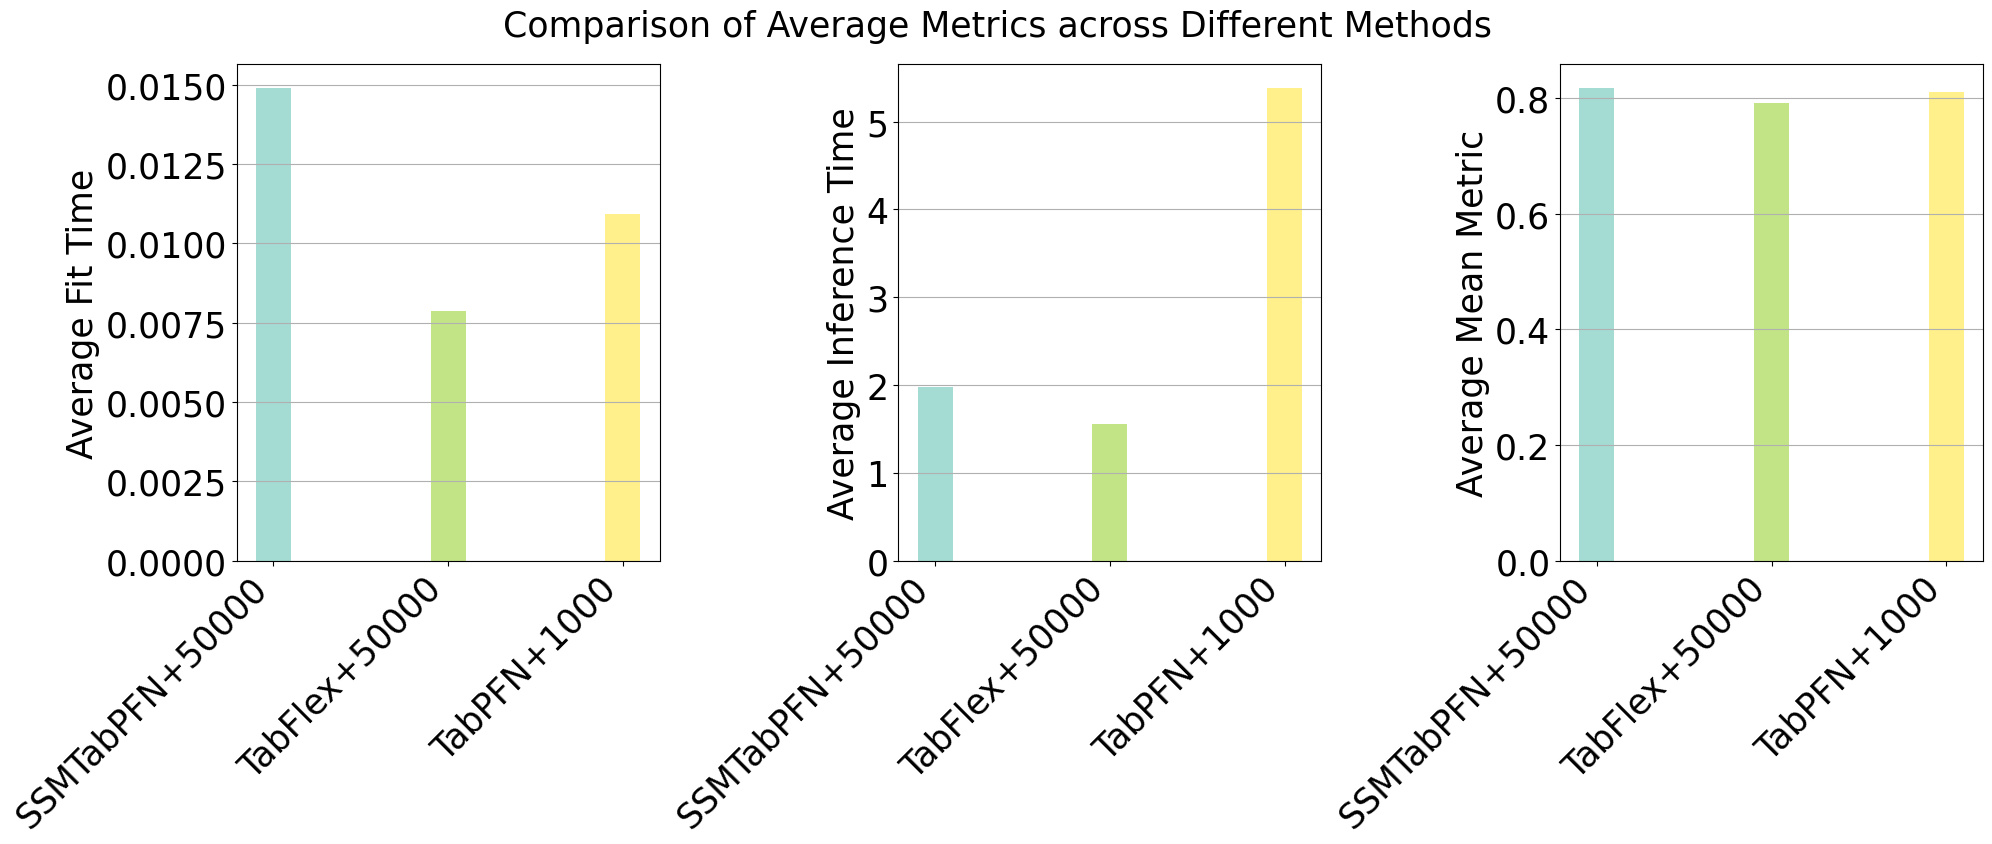

In [35]:
# Calculate averages
metrics = ['fit_time', 'inference_time', 'mean_metric']
methods = [
    # 'SSMTabPFN+1000', 
    # 'SSMTabPFN+10000', 
    'SSMTabPFN+50000', 
    'TabFlex+50000', 
    'TabPFN+1000'
]

averages = {metric: {method: pivot_table[f'{method}_{metric}'].mean() for method in methods} for metric in metrics}

# Prepare for plotting
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
width = 0.2
x = np.arange(len(methods))

# Color map for consistency across subplots
colors = plt.cm.get_cmap('Set3')(np.linspace(0, 1, len(methods)))

# Plot each metric in a separate subplot
for i, metric in enumerate(metrics):
    ax = axes[i]
    values = [averages[metric][method] for method in methods]
    bars = ax.bar(x, values, width, alpha=0.8, color=colors)
    
    ax.set_ylabel(f'Average {metric.replace("_", " ").title()}', fontsize=25)
    ax.tick_params(axis='y', labelsize=25)
    # ax.set_title(f'Comparison of {metric.replace("_", " ").title()}', fontsize=25)
    ax.set_xticks(x, fontsize=25, labels=methods)
    ax.set_xticklabels(methods, rotation=45, ha='right', fontsize=25)
    ax.yaxis.grid(True)
    
    # if i == 2: ax.set_ylim(0.75, 0.85)
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        # ax.text(bar.get_x() + bar.get_width()/2., height,
        #         f'{height:.6f}',
        #         ha='center', va='bottom', rotation=90)

# Adjust layout and display the plot
plt.tight_layout()
plt.suptitle('Comparison of Average Metrics across Different Methods', fontsize=25, y=1.05)
plt.show()

/tmp/ipykernel_2984227/4145321244.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


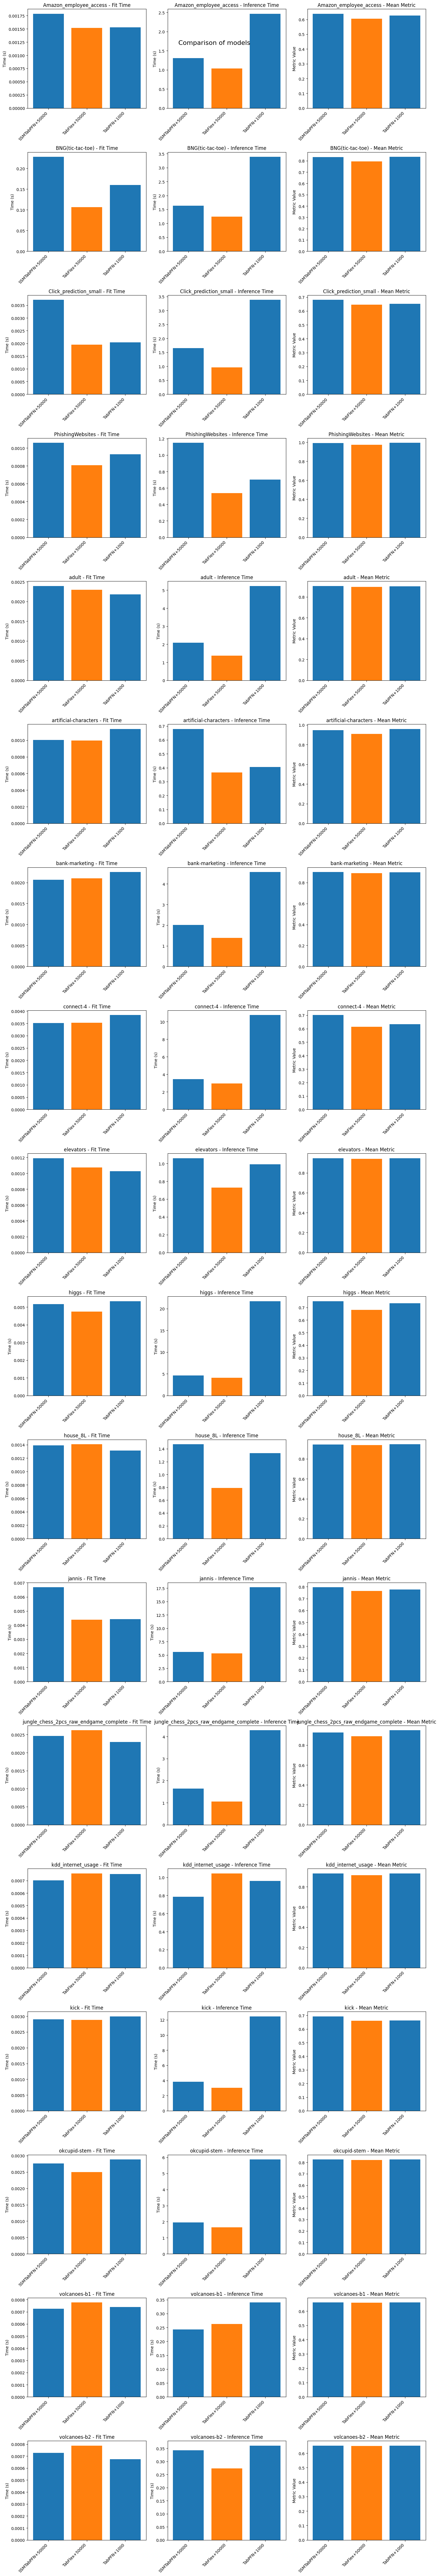

In [36]:
# Set up the plot
datasets = pivot_table['dataset'].unique()
fig, axes = plt.subplots(len(datasets), 3, figsize=(15,(len(datasets)*5)))
fig.suptitle('Comparison of models', fontsize=16)

# Define colors for consistency
colors = ['#1f77b4', '#ff7f0e']  # Blue for SSMTabPFN, Orange for TabFlex

for i, dataset in enumerate(datasets):
    dataset_df = pivot_table[pivot_table['dataset'] == dataset]
    
    # Fit Time
    fit_times = [
        dataset_df[f'{method}_fit_time'].values[0] for method in methods
    ]
    axes[i, 0].bar(methods, fit_times, color=colors)
    axes[i, 0].set_title(f'{dataset} - Fit Time')
    axes[i, 0].set_ylabel('Time (s)')
    
    # Inference Time
    inference_times = [
        dataset_df[f'{method}_inference_time'].values[0] for method in methods
    ]
    axes[i, 1].bar(methods, inference_times, color=colors)
    axes[i, 1].set_title(f'{dataset} - Inference Time')
    axes[i, 1].set_ylabel('Time (s)')
    
    # Mean Metric
    mean_metrics = [
        dataset_df[f'{method}_mean_metric'].values[0] for method in methods
    ]
    axes[i, 2].bar(methods, mean_metrics, color=colors)
    axes[i, 2].set_title(f'{dataset} - Mean Metric')
    axes[i, 2].set_ylabel('Metric Value')

    # Rotate x-axis labels for better readability
    for ax in axes[i]:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()